<a href="https://colab.research.google.com/github/nug1209/Virtual_Experience_KPMG_Data_Analytics/blob/master/KPMG_Customer_Targeting_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We're going to make three models. The first model is regression model to predict total revenue / count of purchase of customers using most of the features in all the tables. Second, we will make clustering model using features that of high importance based on the first regression model. Third, we will make a regression model that predicts total revenue / count of purchase of customers using features available only in new customer list. This third model will be used to make targeting priorities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import datetime as datetime
from IPython.display import Image
import pickle
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans

import plotly
import plotly.express as px
import plotly.graph_objs as go

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Import the Excel file.

In [3]:
path = '/content/drive/MyDrive/Virtual Experience/'


excel_file = 'KPMG_VI_New_raw_data_update_final.xlsx'

df_tr = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='Transactions', header=1)
df_tr_copy = df_tr.copy()
df_new = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='NewCustomerList', header=1)
df_new_copy = df_new.copy()
df_dem = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='CustomerDemographic', header=1)
df_dem_copy = df_dem.copy()
df_adr = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='CustomerAddress', header=1)
df_adr_copy = df_adr.copy()

<ipython-input-3-d2e9f3e24718>:8: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_new = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='NewCustomerList', header=1)
<ipython-input-3-d2e9f3e24718>:10: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_dem = pd.read_excel(open(path + excel_file, 'rb'), sheet_name='CustomerDemographic', header=1)


Check the data

In [4]:
df_tr.head(1)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0


In [5]:
df_new.head(1)

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7,0.875,0.74375,1,1,1.71875


In [6]:
df_dem.head(2)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0


In [7]:
df_adr.head(2)

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10


Process the transaction data.

Drop redundant columns.

In [8]:
df_tr.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [9]:
df_tr = df_tr.drop(columns=['product_first_sold_date', 'product_id'])
df_tr.head(1)

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,1,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62


Convert date column to date format.

In [10]:
df_tr['transaction_date'] = pd.to_datetime(df_tr['transaction_date'], format='%Y-%m-%d')
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    20000 non-null  int64         
 1   customer_id       20000 non-null  int64         
 2   transaction_date  20000 non-null  datetime64[ns]
 3   online_order      19640 non-null  float64       
 4   order_status      20000 non-null  object        
 5   brand             19803 non-null  object        
 6   product_line      19803 non-null  object        
 7   product_class     19803 non-null  object        
 8   product_size      19803 non-null  object        
 9   list_price        20000 non-null  float64       
 10  standard_cost     19803 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 1.7+ MB


Assign a reference date from the latest transaction date.

In [11]:
ref_date = df_tr['transaction_date'].max() + timedelta(days=1)
ref_date

Timestamp('2017-12-31 00:00:00')

In [12]:
df_tr['transaction_to_reference_date'] = ref_date - df_tr['transaction_date']
df_tr.head(3)

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,transaction_to_reference_date
0,1,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,309 days
1,2,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,224 days
2,3,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,76 days


In [13]:
df_tr['profit'] = df_tr['list_price'] - df_tr['standard_cost']
df_tr.head(3)

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,transaction_to_reference_date,profit
0,1,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,309 days,17.87
1,2,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,224 days,1702.55
2,3,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,76 days,1544.61


Discard orders that are canceled.

In [14]:
df_tr = df_tr[df_tr['order_status']=='Approved']

In [15]:
df_tr.head(3)

,transaction_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,transaction_to_reference_date,profit
0,1,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,309 days,17.87
1,2,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,224 days,1702.55
2,3,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,76 days,1544.61


In [16]:
# df_tr['order_status'].unique()
# df_tr.info()

In [17]:
df_tr = pd.get_dummies(data=df_tr, columns=['online_order', 'product_line', 'product_class', 'product_size'])
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19821 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   transaction_id                 19821 non-null  int64          
 1   customer_id                    19821 non-null  int64          
 2   transaction_date               19821 non-null  datetime64[ns] 
 3   order_status                   19821 non-null  object         
 4   brand                          19625 non-null  object         
 5   list_price                     19821 non-null  float64        
 6   standard_cost                  19625 non-null  float64        
 7   transaction_to_reference_date  19821 non-null  timedelta64[ns]
 8   profit                         19625 non-null  float64        
 9   online_order_0.0               19821 non-null  uint8          
 10  online_order_1.0               19821 non-null  uint8          
 11  pr

Drop unused columns.

In [18]:
df_tr = df_tr.drop(columns=['online_order_0.0', 'order_status', 'brand', 'transaction_date', 'list_price', 'standard_cost'])
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19821 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   transaction_id                 19821 non-null  int64          
 1   customer_id                    19821 non-null  int64          
 2   transaction_to_reference_date  19821 non-null  timedelta64[ns]
 3   profit                         19625 non-null  float64        
 4   online_order_1.0               19821 non-null  uint8          
 5   product_line_Mountain          19821 non-null  uint8          
 6   product_line_Road              19821 non-null  uint8          
 7   product_line_Standard          19821 non-null  uint8          
 8   product_line_Touring           19821 non-null  uint8          
 9   product_class_high             19821 non-null  uint8          
 10  product_class_low              19821 non-null  uint8          
 11  pr

Convert the time delta data type to integer.

In [19]:
df_tr['transaction_to_reference_date'] = df_tr['transaction_to_reference_date'].dt.days
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19821 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   transaction_id                 19821 non-null  int64  
 1   customer_id                    19821 non-null  int64  
 2   transaction_to_reference_date  19821 non-null  int64  
 3   profit                         19625 non-null  float64
 4   online_order_1.0               19821 non-null  uint8  
 5   product_line_Mountain          19821 non-null  uint8  
 6   product_line_Road              19821 non-null  uint8  
 7   product_line_Standard          19821 non-null  uint8  
 8   product_line_Touring           19821 non-null  uint8  
 9   product_class_high             19821 non-null  uint8  
 10  product_class_low              19821 non-null  uint8  
 11  product_class_medium           19821 non-null  uint8  
 12  product_size_large             19821 non-null 

In [20]:
df_tr.columns

Index(['transaction_id', 'customer_id', 'transaction_to_reference_date',
       'profit', 'online_order_1.0', 'product_line_Mountain',
       'product_line_Road', 'product_line_Standard', 'product_line_Touring',
       'product_class_high', 'product_class_low', 'product_class_medium',
       'product_size_large', 'product_size_medium', 'product_size_small'],
      dtype='object')

In [21]:
# df.groupby('Courses').aggregate({'Duration':'count','Fee':['min','max']})

df_tr = df_tr.groupby('customer_id').aggregate({'transaction_id':'count',
                                                'transaction_to_reference_date':['min', 'max'],
                                                'profit':'sum',
                                                'online_order_1.0':'sum',
                                                'product_line_Mountain': 'sum',
                                                'product_line_Road': 'sum',
                                                'product_line_Standard': 'sum',
                                                'product_line_Touring': 'sum',
                                                'product_class_high': 'sum',
                                                'product_class_low': 'sum',
                                                'product_class_medium': 'sum',
                                                'product_size_large': 'sum',
                                                'product_size_medium': 'sum',
                                                'product_size_small': 'sum'
                                                })

In [22]:
df_tr.head(3)

transaction_id transaction_to_reference_date        profit  \
                     count                           min  max      sum   
customer_id                                                              
1                       11                             8  360  3018.09   
2                        3                           129  241  2226.26   
3                        8                           103  311  3362.81   

            online_order_1.0 product_line_Mountain product_line_Road  \
                         sum                   sum               sum   
customer_id                                                            
1                          6                     1                 3   
2                          1                     0                 0   
3                          1                     1                 3   

            product_line_Standard product_line_Touring product_class_high  \
                              sum                  sum                sum   
customer_id                                                                 
1                               7                    0                  1   
2                               3                    0                  0   
3                               4                    0                  1   

            product_class_low product_class_medium product_size_large  \
                          sum                  sum                sum   
customer_id                                                             
1                           2                    8                  0   
2                           0                    3                  0   
3                           3                    4                  3   

            product_size_medium product_size_small  
                            sum                sum  
customer_id                                         
1                             9                  2  
2                             3                  0  
3                             3                  2

In [23]:
df_tr.columns = df_tr.columns.get_level_values(0)
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 1 to 5034
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   transaction_id                 3493 non-null   int64  
 1   transaction_to_reference_date  3493 non-null   int64  
 2   transaction_to_reference_date  3493 non-null   int64  
 3   profit                         3493 non-null   float64
 4   online_order_1.0               3493 non-null   uint8  
 5   product_line_Mountain          3493 non-null   uint8  
 6   product_line_Road              3493 non-null   uint8  
 7   product_line_Standard          3493 non-null   uint8  
 8   product_line_Touring           3493 non-null   uint8  
 9   product_class_high             3493 non-null   uint8  
 10  product_class_low              3493 non-null   uint8  
 11  product_class_medium           3493 non-null   uint8  
 12  product_size_large             3493 non-null   u

In [24]:
df_tr.columns

Index(['transaction_id', 'transaction_to_reference_date',
       'transaction_to_reference_date', 'profit', 'online_order_1.0',
       'product_line_Mountain', 'product_line_Road', 'product_line_Standard',
       'product_line_Touring', 'product_class_high', 'product_class_low',
       'product_class_medium', 'product_size_large', 'product_size_medium',
       'product_size_small'],
      dtype='object')

In [25]:
df_tr = df_tr.rename(columns = {'transaction_id':'transaction_count',
                                df_tr.columns[1]:'days_since_latest_purchase',
                                df_tr.columns[2]:'days_since_first_purchase',
                                'online_order_1.0':'online_order_count',
                                'profit':'profit_sum',
                                'product_line_Mountain': 'product_line_mountain_count',
                                'product_line_Road': 'product_line_road_count',
                                'product_line_Standard': 'product_line_standard_count',
                                'product_line_Touring': 'product_line_touring_count',
                                'product_class_high': 'product_class_high_count',
                                'product_class_low': 'product_class_low_count',
                                'product_class_medium': 'product_class_medium_count',
                                'product_size_large': 'product_size_large_count',
                                'product_size_medium': 'product_size_medium_count',
                                'product_size_small': 'product_size_small_count'})

df_tr.columns.values[2] = 'days_since_last_purchase'
df_tr.columns

Index(['transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count'],
      dtype='object')

In [26]:
df_tr = df_tr.reset_index()
df_tr.head(3)

,customer_id,transaction_count,days_since_first_purchase,days_since_last_purchase,profit_sum,online_order_count,product_line_mountain_count,product_line_road_count,product_line_standard_count,product_line_touring_count,product_class_high_count,product_class_low_count,product_class_medium_count,product_size_large_count,product_size_medium_count,product_size_small_count
0,1,11,8,360,3018.09,6,1,3,7,0,1,2,8,0,9,2
1,2,3,129,241,2226.26,1,0,0,3,0,0,0,3,0,3,0
2,3,8,103,311,3362.81,1,1,3,4,0,1,3,4,3,3,2


In [27]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  3493 non-null   int64  
 1   transaction_count            3493 non-null   int64  
 2   days_since_first_purchase    3493 non-null   int64  
 3   days_since_last_purchase     3493 non-null   int64  
 4   profit_sum                   3493 non-null   float64
 5   online_order_count           3493 non-null   uint8  
 6   product_line_mountain_count  3493 non-null   uint8  
 7   product_line_road_count      3493 non-null   uint8  
 8   product_line_standard_count  3493 non-null   uint8  
 9   product_line_touring_count   3493 non-null   uint8  
 10  product_class_high_count     3493 non-null   uint8  
 11  product_class_low_count      3493 non-null   uint8  
 12  product_class_medium_count   3493 non-null   uint8  
 13  product_size_large

Process the customer demographic table.

In [28]:
df_dem.head(3)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0


In [29]:
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

Filter out deceased customers.

In [30]:
# df_dem['deceased_indicator'].unique()
df_dem = df_dem[df_dem['deceased_indicator']=='N']
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3998 non-null   int64         
 1   first_name                           3998 non-null   object        
 2   last_name                            3873 non-null   object        
 3   gender                               3998 non-null   object        
 4   past_3_years_bike_related_purchases  3998 non-null   int64         
 5   DOB                                  3911 non-null   datetime64[ns]
 6   job_title                            3492 non-null   object        
 7   job_industry_category                3342 non-null   object        
 8   wealth_segment                       3998 non-null   object        
 9   deceased_indicator                   3998 non-null   object        
 10  default     

Remove unused columns.

In [31]:
df_dem = df_dem.drop(columns=['first_name', 'last_name', 'deceased_indicator', 'default'])
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3998 non-null   int64         
 1   gender                               3998 non-null   object        
 2   past_3_years_bike_related_purchases  3998 non-null   int64         
 3   DOB                                  3911 non-null   datetime64[ns]
 4   job_title                            3492 non-null   object        
 5   job_industry_category                3342 non-null   object        
 6   wealth_segment                       3998 non-null   object        
 7   owns_car                             3998 non-null   object        
 8   tenure                               3911 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 312.3+ KB


Clean the columns.

In [32]:
df_dem['gender'].unique()

array(['F', 'Male', 'Female', 'U', 'Femal', 'M'], dtype=object)

In [33]:
# df_dem['job_title'].unique()
df_dem['job_industry_category'].unique()

array(['Health', 'Financial Services', 'Property', 'IT', nan, 'Retail',
       'Argiculture', 'Manufacturing', 'Telecommunications',
       'Entertainment'], dtype=object)

Replace wrong values in the gender column.

In [34]:
# df.replace({0: 10, 1: 100})
df_dem['gender'] = df_dem['gender'].replace({'F':'Female', 'Femal':'Female', 'M':'Male', 'U':'Not Identify'})
len(df_dem[df_dem['gender']=='Not Identify'])

88

In [35]:
df_dem['age'] = (ref_date - df_dem['DOB']).dt.days / 365
df_dem['age'] = df_dem['age'].fillna(df_dem['age'].mean())
df_dem['age'] = df_dem['age'].astype(int)
df_dem.head(3)

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,age
0,1,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,64
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,37
2,3,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,Yes,15.0,63


Remove unused columns again.

In [36]:
df_dem = df_dem.drop(columns=['DOB'])
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3998 non-null   int64  
 1   gender                               3998 non-null   object 
 2   past_3_years_bike_related_purchases  3998 non-null   int64  
 3   job_title                            3492 non-null   object 
 4   job_industry_category                3342 non-null   object 
 5   wealth_segment                       3998 non-null   object 
 6   owns_car                             3998 non-null   object 
 7   tenure                               3911 non-null   float64
 8   age                                  3998 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 312.3+ KB


Process the address table.

In [37]:
df_adr.head(3)

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9


Check the columns.

In [38]:
len(df_adr['postcode'].unique())

873

Remove unused column.

In [39]:
df_adr = df_adr.drop(columns=['address', 'postcode', 'country'])
df_adr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   state               3999 non-null   object
 2   property_valuation  3999 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


Clean the state column.

In [40]:
df_adr['state'].unique()

array(['New South Wales', 'QLD', 'VIC', 'NSW', 'Victoria'], dtype=object)

In [41]:
df_adr['state'] = df_adr['state'].replace({'New South Wales':'NSW', 'Victoria':'VIC'})
df_adr.head()

,customer_id,state,property_valuation
0,1,NSW,10
1,2,NSW,10
2,4,QLD,9
3,5,NSW,4
4,6,VIC,9


In [42]:
df_adr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   state               3999 non-null   object
 2   property_valuation  3999 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


In [43]:
df_dem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3998 non-null   int64  
 1   gender                               3998 non-null   object 
 2   past_3_years_bike_related_purchases  3998 non-null   int64  
 3   job_title                            3492 non-null   object 
 4   job_industry_category                3342 non-null   object 
 5   wealth_segment                       3998 non-null   object 
 6   owns_car                             3998 non-null   object 
 7   tenure                               3911 non-null   float64
 8   age                                  3998 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 312.3+ KB


In [44]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  3493 non-null   int64  
 1   transaction_count            3493 non-null   int64  
 2   days_since_first_purchase    3493 non-null   int64  
 3   days_since_last_purchase     3493 non-null   int64  
 4   profit_sum                   3493 non-null   float64
 5   online_order_count           3493 non-null   uint8  
 6   product_line_mountain_count  3493 non-null   uint8  
 7   product_line_road_count      3493 non-null   uint8  
 8   product_line_standard_count  3493 non-null   uint8  
 9   product_line_touring_count   3493 non-null   uint8  
 10  product_class_high_count     3493 non-null   uint8  
 11  product_class_low_count      3493 non-null   uint8  
 12  product_class_medium_count   3493 non-null   uint8  
 13  product_size_large

In [45]:
df = pd.merge(df_tr, df_dem, on='customer_id')
df = pd.merge(df, df_adr, on='customer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3487 entries, 0 to 3486
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3487 non-null   int64  
 1   transaction_count                    3487 non-null   int64  
 2   days_since_first_purchase            3487 non-null   int64  
 3   days_since_last_purchase             3487 non-null   int64  
 4   profit_sum                           3487 non-null   float64
 5   online_order_count                   3487 non-null   uint8  
 6   product_line_mountain_count          3487 non-null   uint8  
 7   product_line_road_count              3487 non-null   uint8  
 8   product_line_standard_count          3487 non-null   uint8  
 9   product_line_touring_count           3487 non-null   uint8  
 10  product_class_high_count             3487 non-null   uint8  
 11  product_class_low_count       

In [46]:
df['average_profit_per_transaction'] = df['profit_sum'] / df['transaction_count']
df.head()

,customer_id,transaction_count,days_since_first_purchase,days_since_last_purchase,profit_sum,online_order_count,product_line_mountain_count,product_line_road_count,product_line_standard_count,product_line_touring_count,...,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,state,property_valuation,average_profit_per_transaction
0,1,11,8,360,3018.09,6,1,3,7,0,...,93,Executive Secretary,Health,Mass Customer,Yes,11.0,64,NSW,10,274.371818
1,2,3,129,241,2226.26,1,0,0,3,0,...,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,37,NSW,10,742.086667
2,4,2,196,272,220.57,1,0,0,2,0,...,33,NaN,IT,Mass Customer,No,7.0,56,QLD,9,110.285000
3,5,6,17,303,2394.94,2,1,3,2,0,...,56,Senior Editor,NaN,Affluent Customer,Yes,8.0,40,NSW,4,399.156667
4,6,5,65,337,3946.55,2,0,0,5,0,...,35,NaN,Retail,High Net Worth,Yes,13.0,51,VIC,9,789.310000


In [47]:
df['job_title'].unique()

array(['Executive Secretary', 'Administrative Officer', nan,
       'Senior Editor', 'Media Manager I',
       'Business Systems Development Analyst', 'Nuclear Power Engineer',
       'Developer I', 'Account Executive', 'Junior Executive',
       'Media Manager IV', 'Sales Associate', 'Professor',
       'Geological Engineer', 'Project Manager', 'Safety Technician I',
       'Research Assistant I', 'Accounting Assistant III', 'Editor',
       'Research Nurse', 'Senior Quality Engineer',
       'Safety Technician III', 'Staff Accountant III', 'Legal Assistant',
       'Product Engineer', 'Information Systems Manager',
       'VP Quality Control', 'Social Worker', 'Senior Cost Accountant',
       'Assistant Media Planner', 'Payment Adjustment Coordinator',
       'Food Chemist', 'Accountant III', 'Director of Sales',
       'Senior Financial Analyst', 'Registered Nurse',
       'Biostatistician II', 'Computer Systems Analyst II',
       'Software Test Engineer II', 'Paralegal', 'VP Sales

Visualize the data.

In [48]:
# num_columns = list(df.select_dtypes('number').columns)

In [49]:
df.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

The age column needs cleaning.

In [50]:
df['age'].max()

174

In [51]:
df = df[df['age'] < 75]
# df.info()

The owns car column needs fixing.

In [52]:
df['owns_car'] = df['owns_car'].replace({'Yes':1, 'No':0})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3483 entries, 0 to 3486
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3483 non-null   int64  
 1   transaction_count                    3483 non-null   int64  
 2   days_since_first_purchase            3483 non-null   int64  
 3   days_since_last_purchase             3483 non-null   int64  
 4   profit_sum                           3483 non-null   float64
 5   online_order_count                   3483 non-null   uint8  
 6   product_line_mountain_count          3483 non-null   uint8  
 7   product_line_road_count              3483 non-null   uint8  
 8   product_line_standard_count          3483 non-null   uint8  
 9   product_line_touring_count           3483 non-null   uint8  
 10  product_class_high_count             3483 non-null   uint8  
 11  product_class_low_count       

<ipython-input-52-5ca8e4cd3af0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['owns_car'] = df['owns_car'].replace({'Yes':1, 'No':0})


Visualize the data to identify patterns and anomalies.

In [53]:
viz_num = ['average_profit_per_transaction',
           'online_order_count',
           'days_since_first_purchase',
           'days_since_last_purchase',
           'past_3_years_bike_related_purchases',
           'owns_car',
           'tenure',
           'age',
           'property_valuation']

In [54]:
# sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
# sns.pairplot(df[viz_num], plot_kws={'s':3})

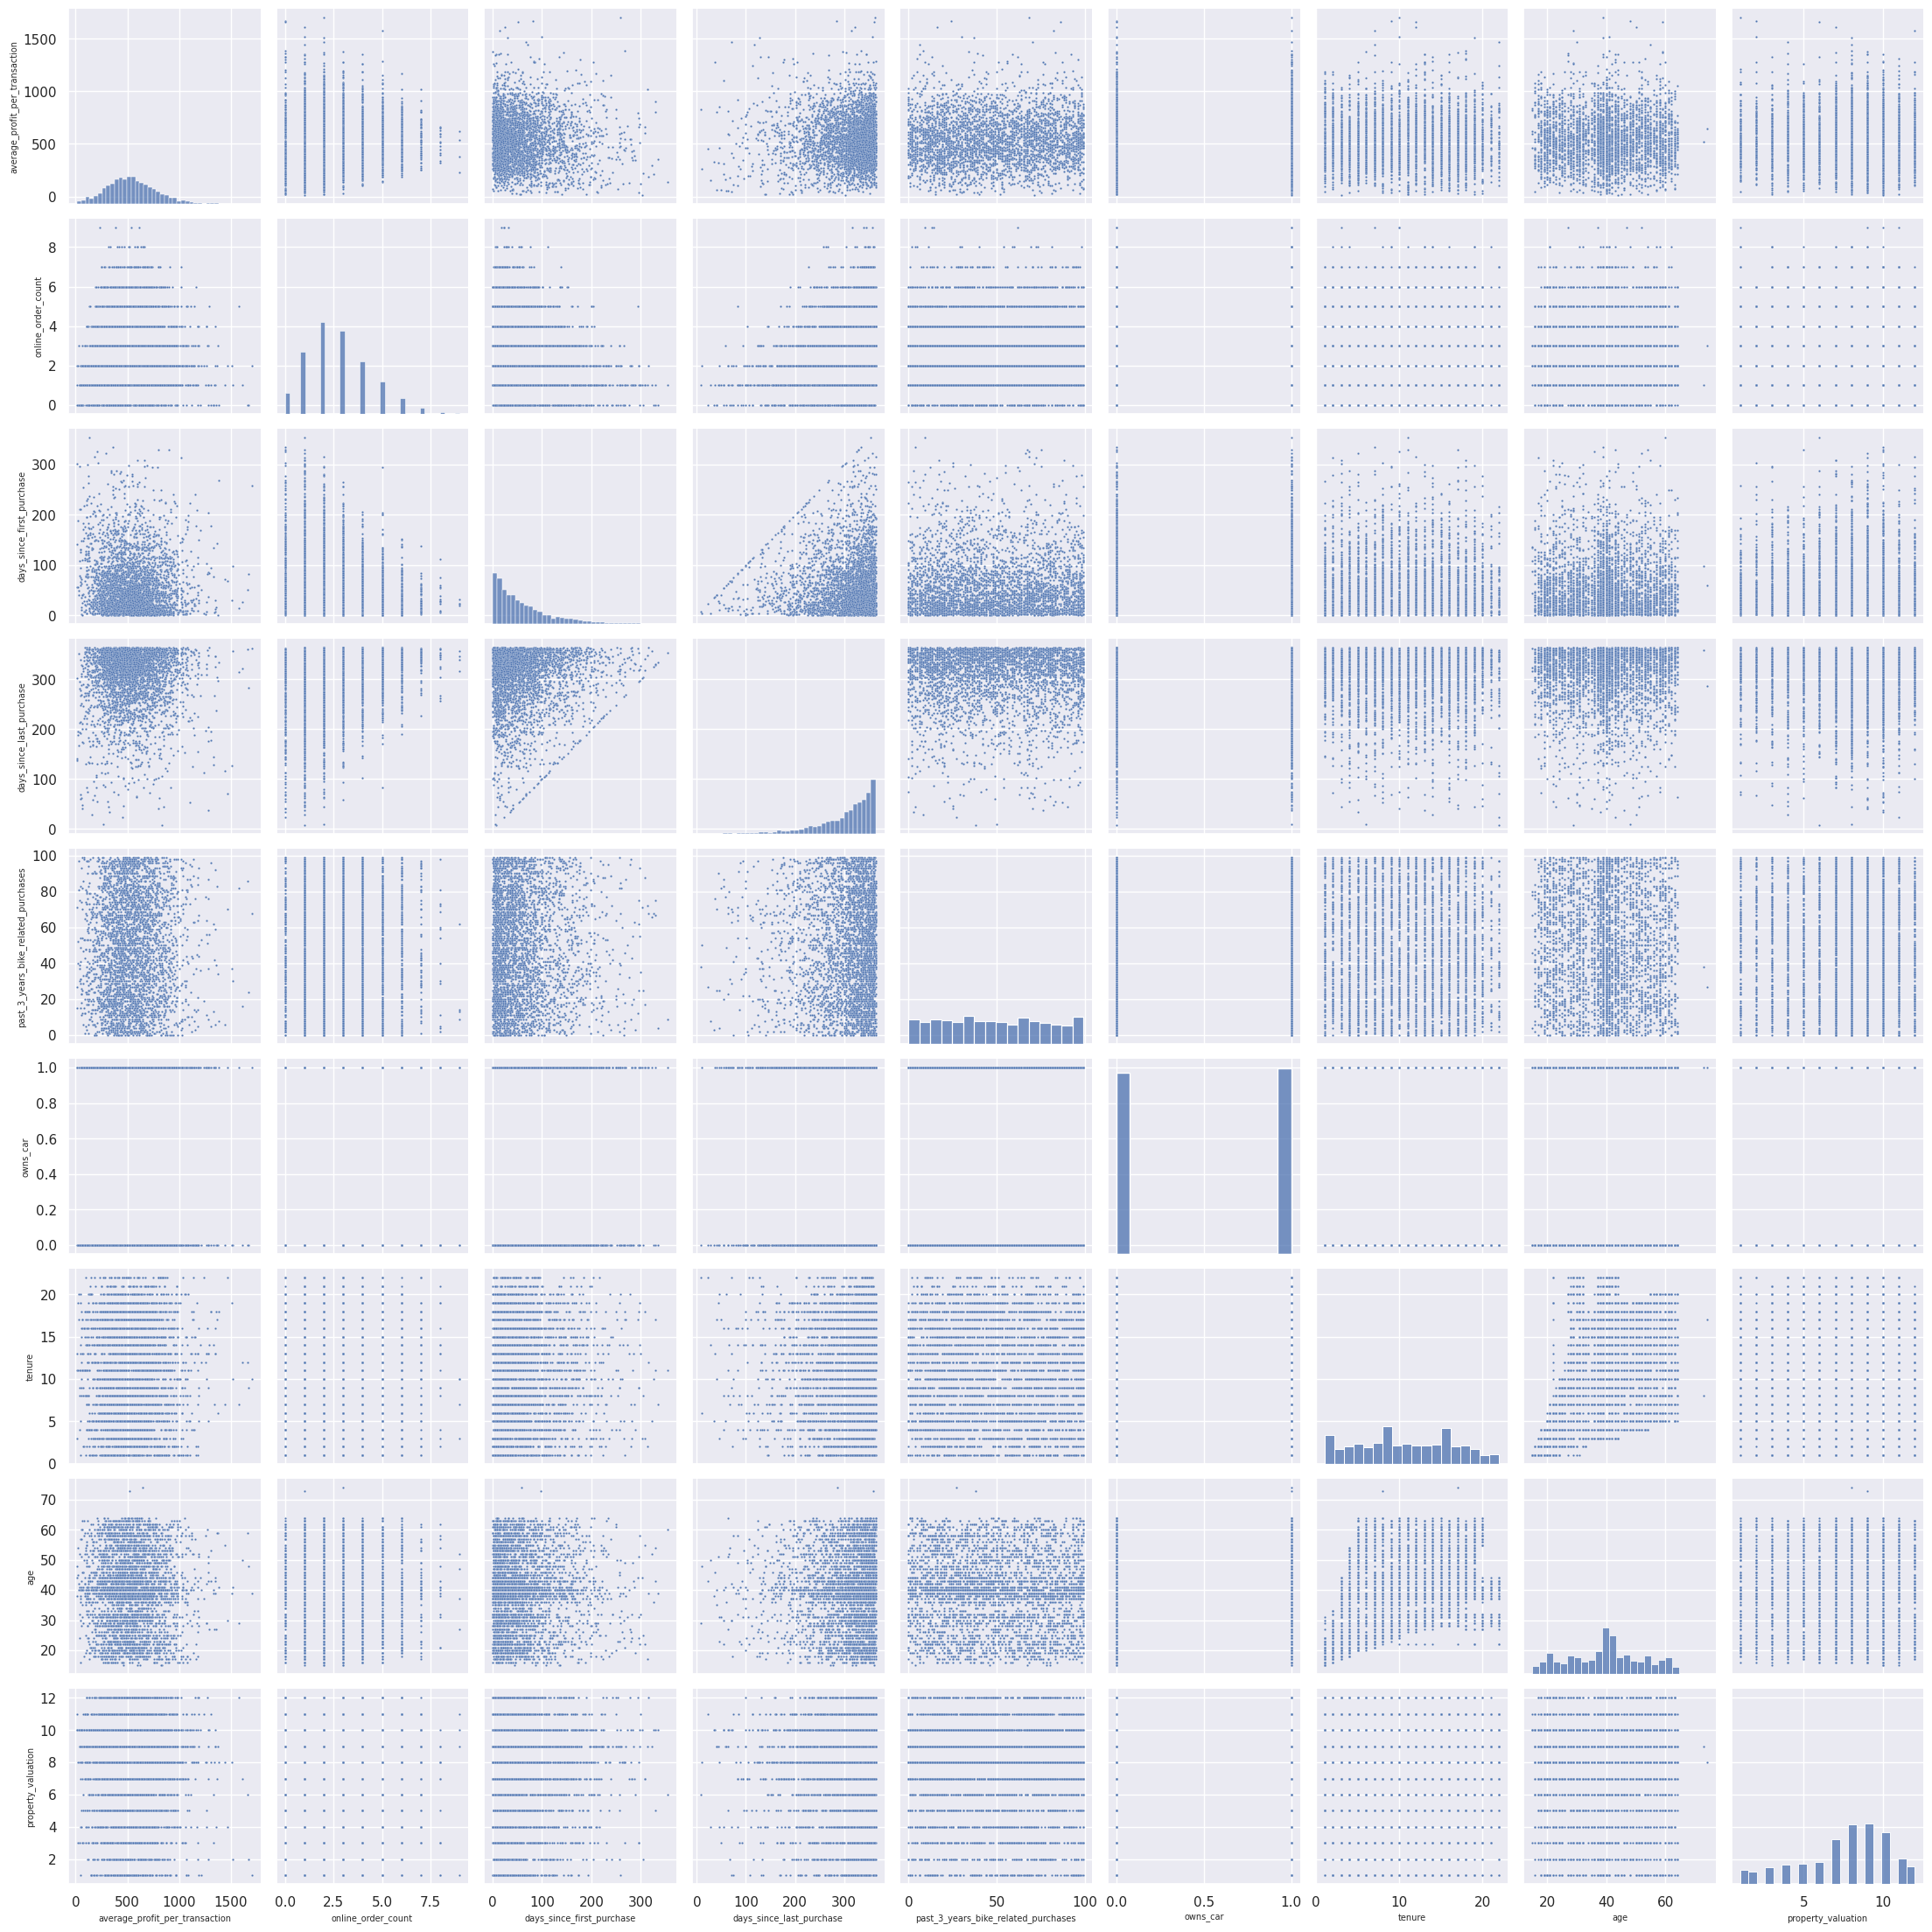

In [55]:
Image(path + 'kpmg_plot1.png')

In [56]:
df.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

In [57]:
# viz_cat = ['gender', 'wealth_segment', 'job_title', 'job_industry_category']
# idx = 0
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# for i in list(range(2)):
#   for j in list(range(2)):
#     if idx < 4:
#       ax = sns.countplot(ax=axes[i, j], data=df, x=viz_cat[idx], lw=0, order = df[viz_cat[idx]].value_counts().index)
#       ax.set(xticklabels=[])
#       idx +=1

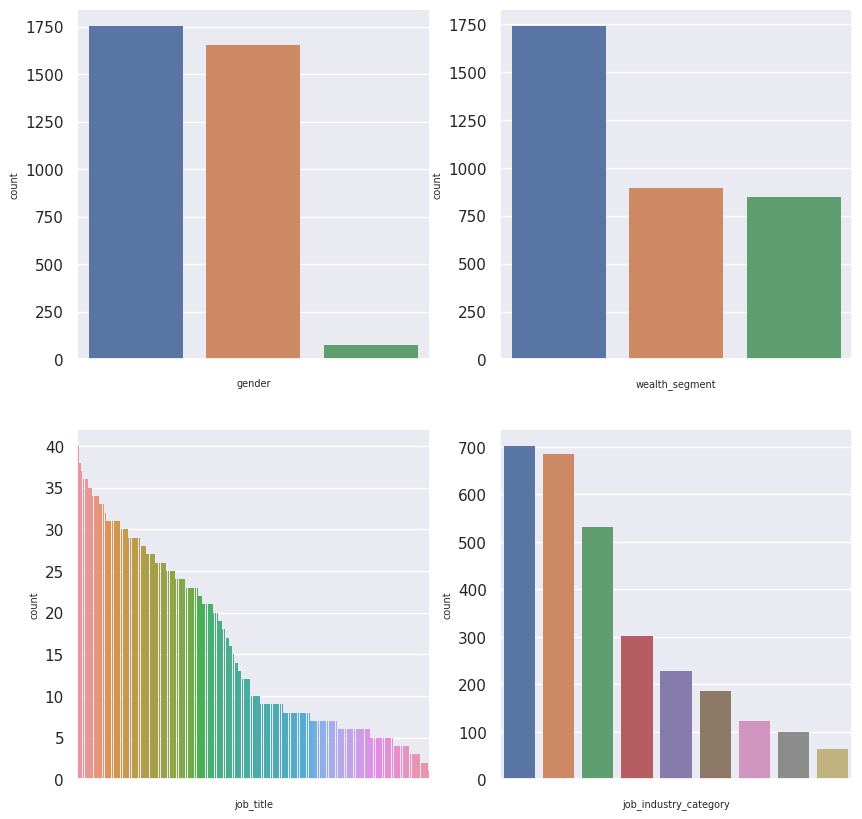

In [58]:
Image(path + 'kpmg_plot2.png')

In [59]:
df.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

In [60]:
# viz_num2 = ['product_line_mountain_count', 'product_line_road_count', 'product_line_standard_count', 'product_line_touring_count',
#             'product_class_high_count', 'product_class_low_count', 'product_class_medium_count', 'product_size_large_count',
#             'product_size_medium_count', 'product_size_small_count', 'average_profit_per_transaction']
# sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
# sns.pairplot(df[viz_num2], plot_kws={'s':3})

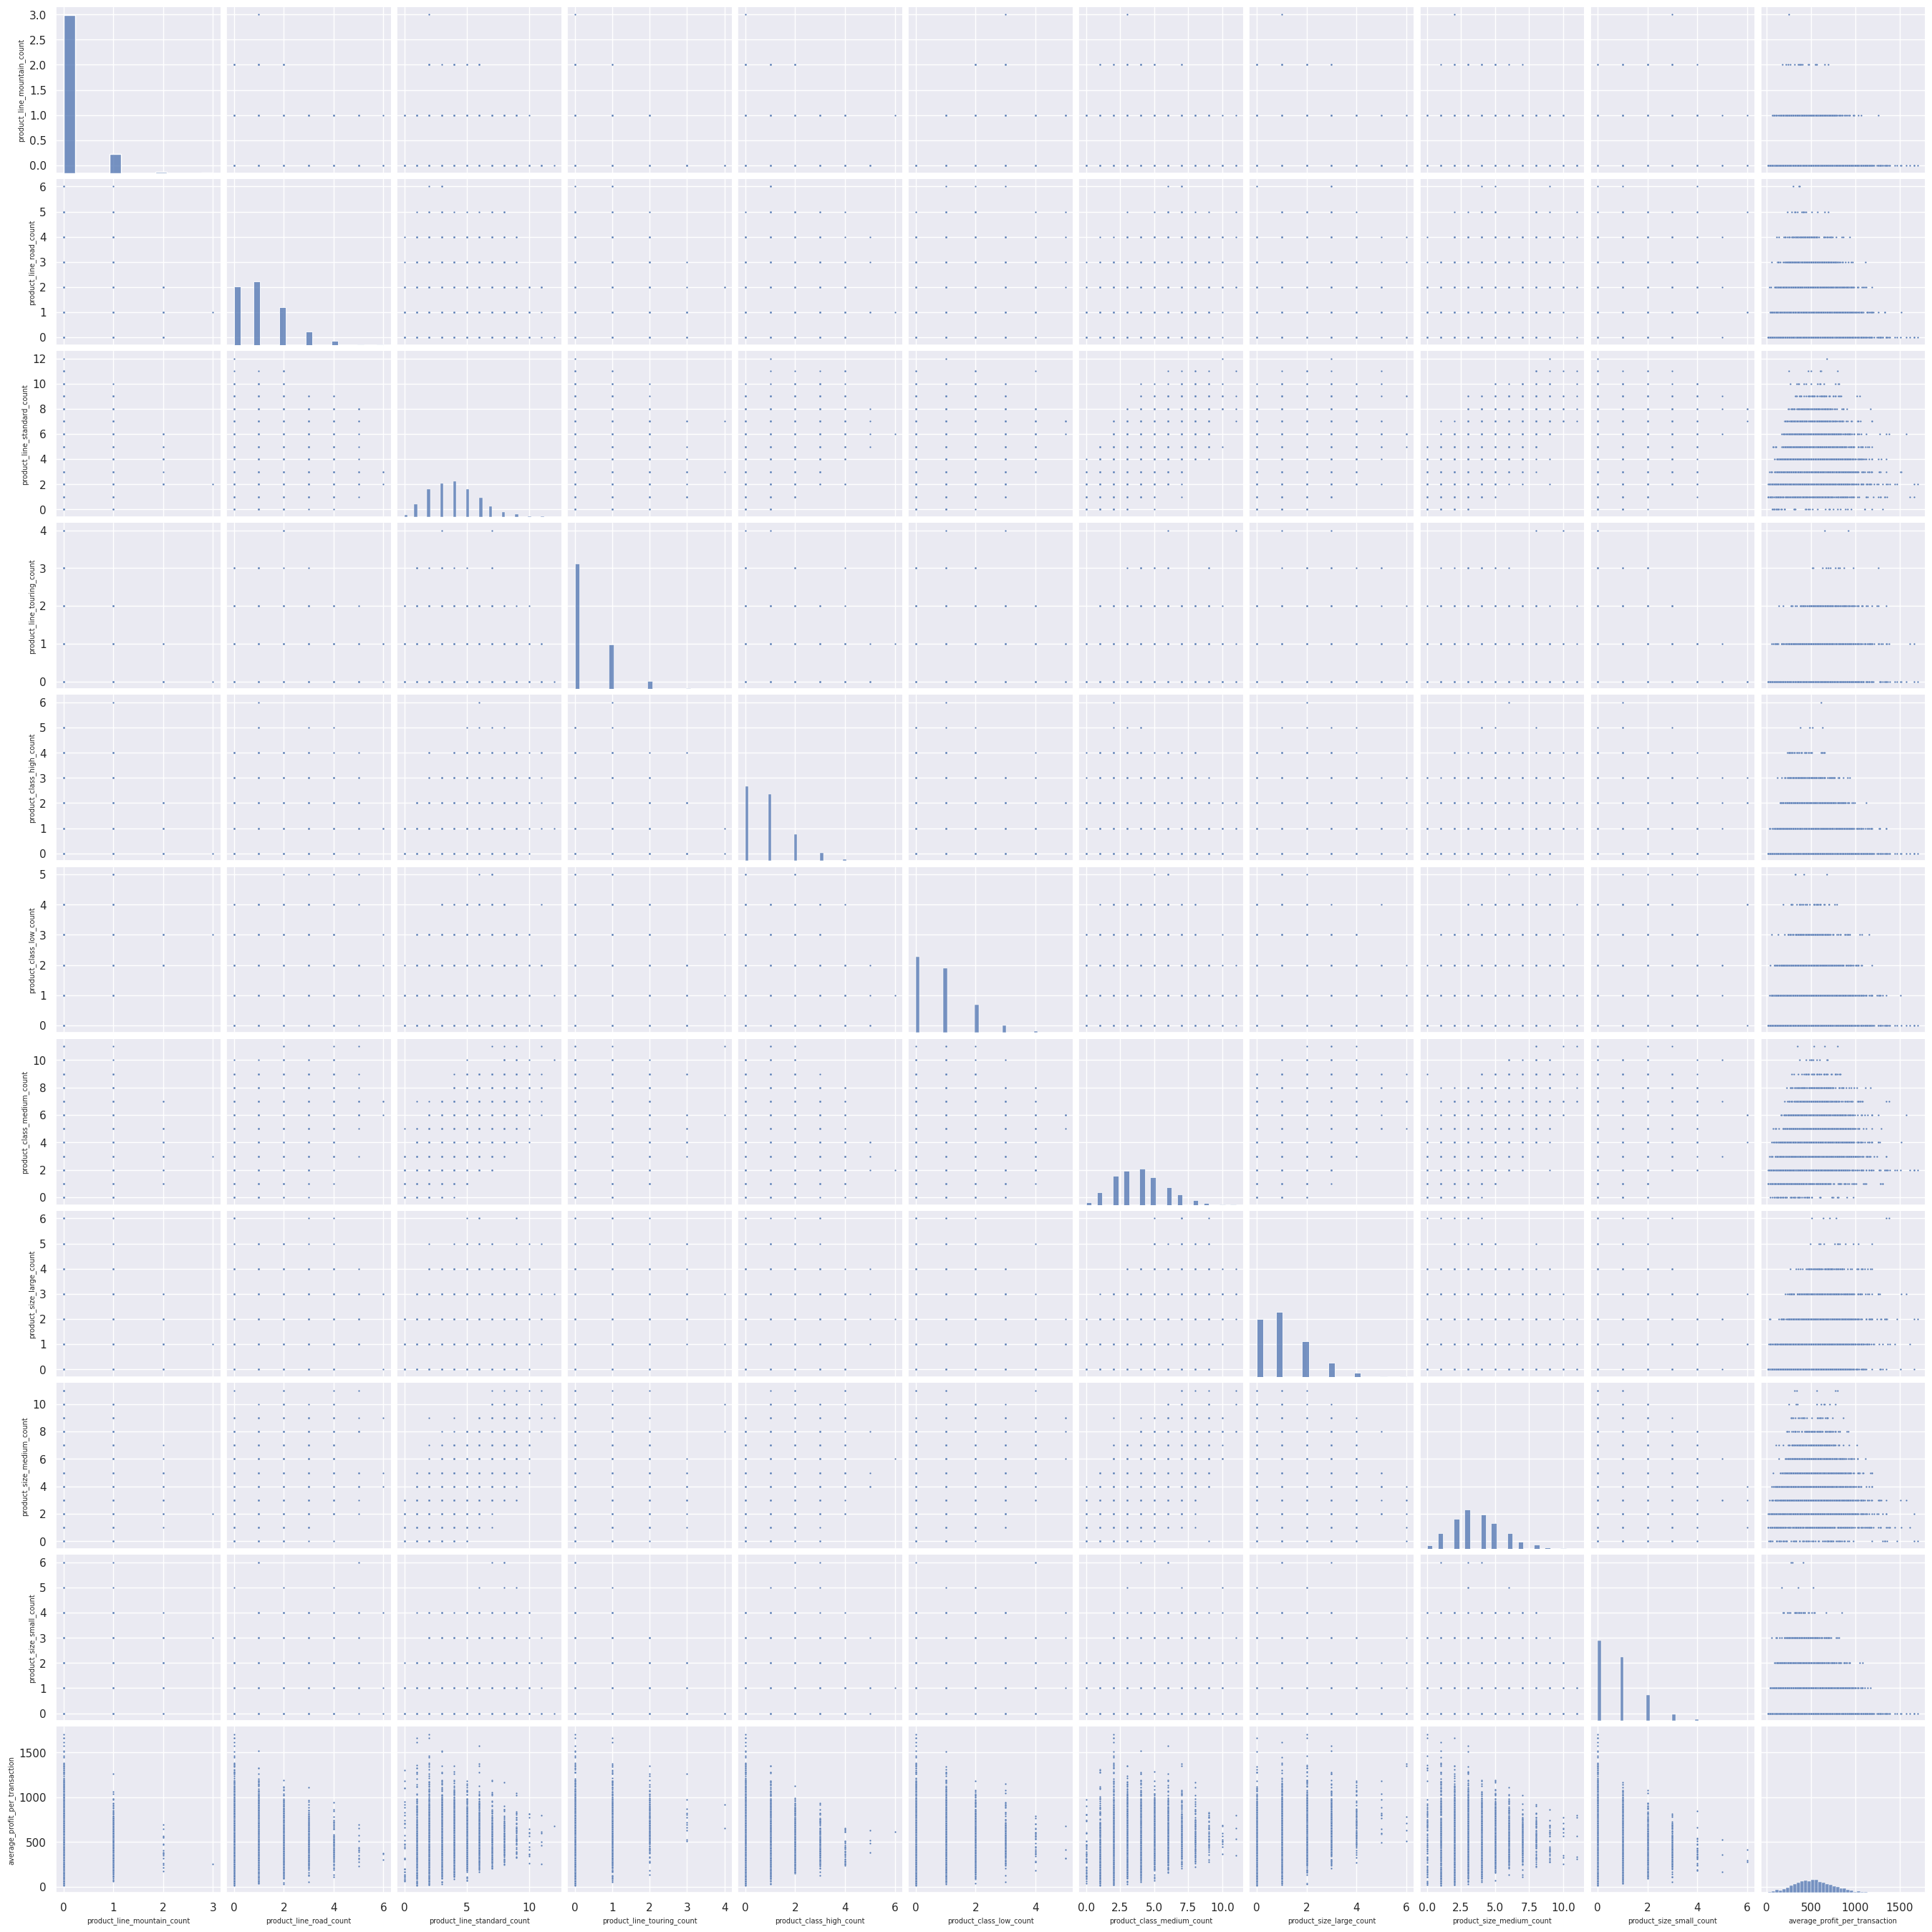

In [61]:
Image(path + 'kpmg_plot3.png')

In [62]:
df.head(3)

,customer_id,transaction_count,days_since_first_purchase,days_since_last_purchase,profit_sum,online_order_count,product_line_mountain_count,product_line_road_count,product_line_standard_count,product_line_touring_count,...,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,state,property_valuation,average_profit_per_transaction
0,1,11,8,360,3018.09,6,1,3,7,0,...,93,Executive Secretary,Health,Mass Customer,1,11.0,64,NSW,10,274.371818
1,2,3,129,241,2226.26,1,0,0,3,0,...,81,Administrative Officer,Financial Services,Mass Customer,1,16.0,37,NSW,10,742.086667
2,4,2,196,272,220.57,1,0,0,2,0,...,33,NaN,IT,Mass Customer,0,7.0,56,QLD,9,110.285000


Copy the stable state of the main data frame.

In [63]:
df_copy = df.copy()

Reverting the data frame to stable state. Use this just for tweaking the features.

In [64]:
# df = df_copy

There are still null values in the columns. Fill them.

In [65]:
df = df.fillna({'job_industry_category':'No Info', 'tenure':0})

Drop columns that cause leakage.

In [66]:
# df = df.drop(columns=['profit_sum', 'transaction_count'])

df = df.drop(columns=['profit_sum'])

Start modeling.

In [67]:
df = df.drop(columns=['customer_id', 'job_title'])

Create dummy variables for several categorical columns.

In [68]:
df = pd.get_dummies(data=df, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])
df.head()

,transaction_count,days_since_first_purchase,days_since_last_purchase,online_order_count,product_line_mountain_count,product_line_road_count,product_line_standard_count,product_line_touring_count,product_class_high_count,product_class_low_count,...,job_industry_category_No Info,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,state_NSW,state_QLD,state_VIC
0,11,8,360,6,1,3,7,0,1,2,...,0,0,0,0,0,0,1,1,0,0
1,3,129,241,1,0,0,3,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,2,196,272,1,0,0,2,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,6,17,303,2,1,3,2,0,1,2,...,1,0,0,0,1,0,0,1,0,0
4,5,65,337,2,0,0,5,0,1,0,...,0,0,1,0,0,1,0,0,0,1


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3483 entries, 0 to 3486
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   transaction_count                         3483 non-null   int64  
 1   days_since_first_purchase                 3483 non-null   int64  
 2   days_since_last_purchase                  3483 non-null   int64  
 3   online_order_count                        3483 non-null   uint8  
 4   product_line_mountain_count               3483 non-null   uint8  
 5   product_line_road_count                   3483 non-null   uint8  
 6   product_line_standard_count               3483 non-null   uint8  
 7   product_line_touring_count                3483 non-null   uint8  
 8   product_class_high_count                  3483 non-null   uint8  
 9   product_class_low_count                   3483 non-null   uint8  
 10  product_class_medium_count          

In [70]:
X_unscaled = df.drop(columns = ['average_profit_per_transaction'])
y = df['average_profit_per_transaction']

scaler = StandardScaler()
scaler.fit(X_unscaled)
X = scaler.transform(X_unscaled)

Train the model only if there is no existing model file in the directory.

In [71]:
rf_model_file = 'kpmg_rf_model_file.pkl'

def cv_hyperparameter_rf(X, y):

  if (os.path.isfile(rf_model_file)==False):

    rf = RandomForestRegressor()
    cv = KFold(n_splits=5)
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)

    print('MEAN CROSS-VALIDATION SCORE: ', grid_search.best_score_)
    print('BEST HYPERPARAMETERS: ', grid_search.best_params_)
    print('Parameter tuning with cross-validation finished. Starting the model training with best performing parameters...')
    
    n_estimators = grid_search.best_params_['n_estimators']
    max_depth = grid_search.best_params_['max_depth']

    rf_model = train_rf(X, y, n_estimators, max_depth)
  
    return rf_model
    
  else: print('There is already a saved model in the directory.')

def train_rf(X, y, n_estimators, max_depth):

  rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=12)
  rf_model = rf.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)
  mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

  print('MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL: ', mae)

  pickle.dump(rf_model, open(rf_model_file, 'wb'))

  return rf_model

In [72]:
cv_hyperparameter_rf(X, y)

MEAN CROSS-VALIDATION SCORE:  0.24829761089329033
BEST HYPERPARAMETERS:  {'max_depth': 7, 'n_estimators': 300}
Parameter tuning with cross-validation finished. Starting the model training with best performing parameters...
MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL:  160.12200227983013


RandomForestRegressor(max_depth=7, n_estimators=300)

Get the mean of the target variable to compare with the MAE of the model.

In [73]:
y.mean()

545.0305051807222

Visualize feature importances.

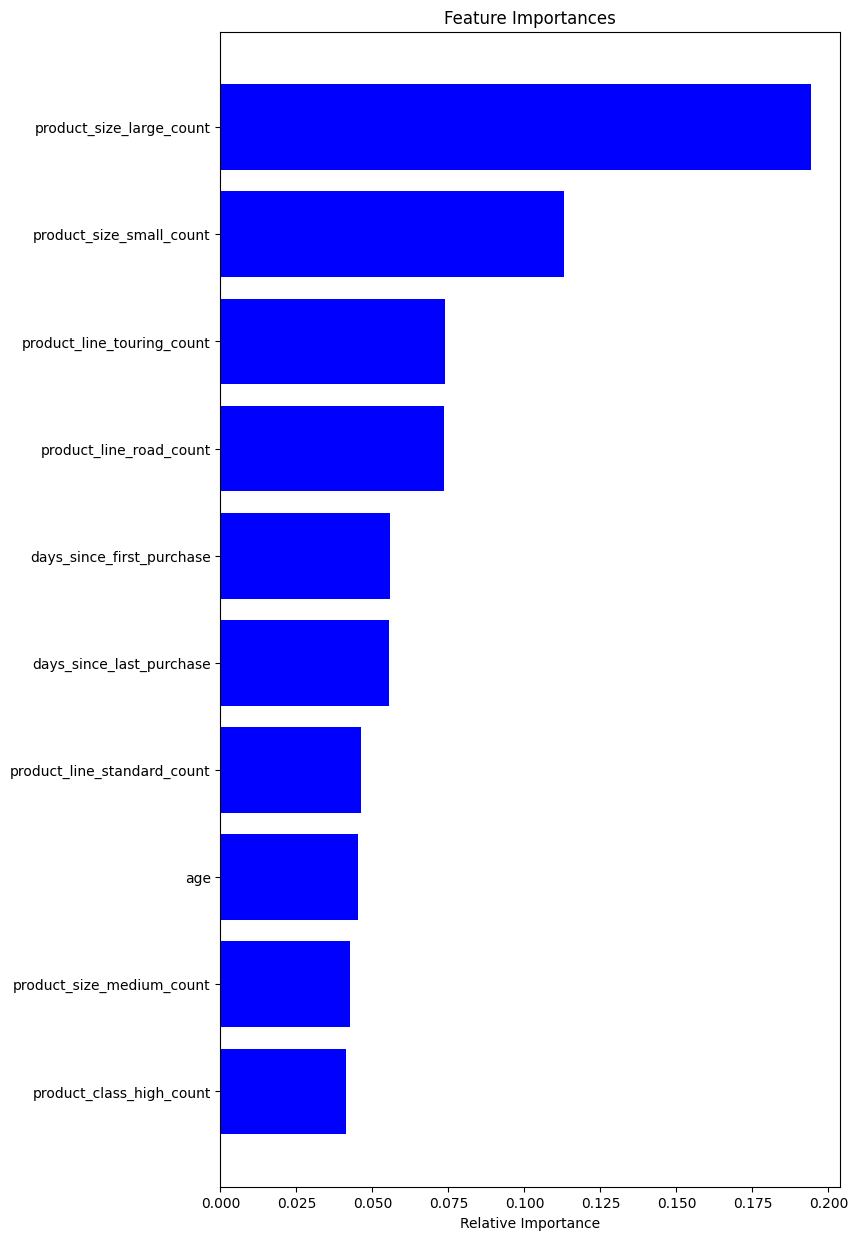

In [74]:
rf_model = pickle.load(open(rf_model_file, 'rb'))

features = [i.split("__")[0] for i in X_unscaled.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

fig, ax = plt.subplots(figsize=(8, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

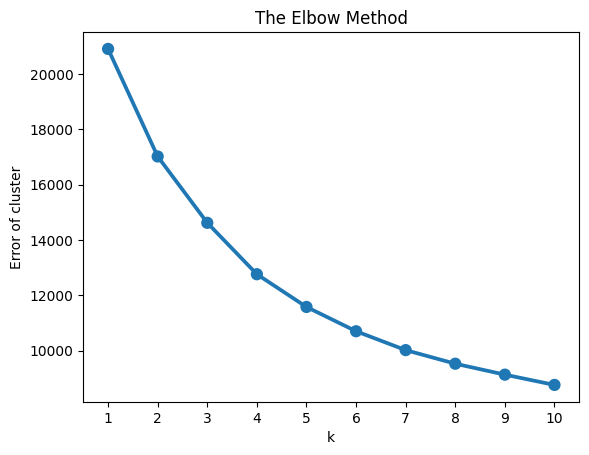

In [75]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count', 'product_line_standard_count', 'days_since_last_purchase']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

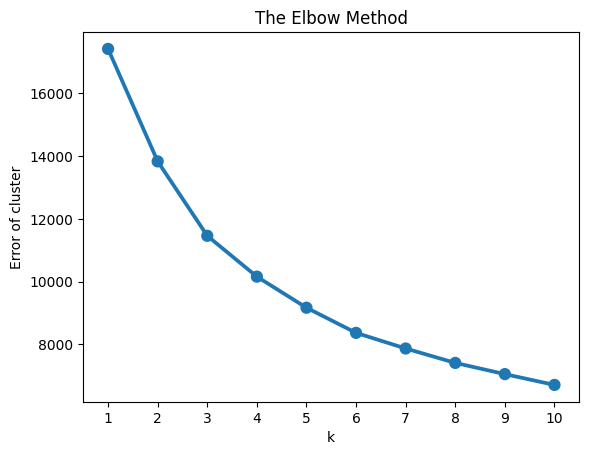

In [76]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count', 'product_line_standard_count']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

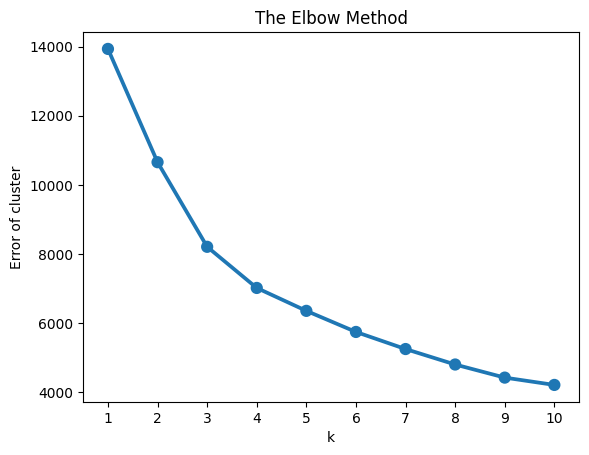

In [77]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

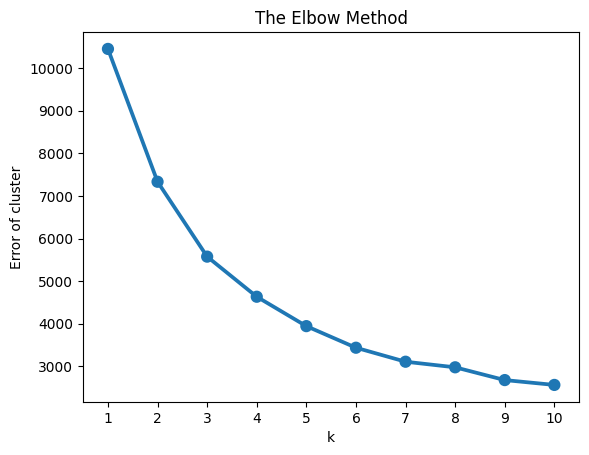

In [78]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()

In [79]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'product_line_touring_count']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

model = KMeans(n_clusters = 3, random_state=12)

model.fit(X_cluster_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=12)

In [80]:
X_cluster = X_cluster.assign(cluster = model.labels_)

X_cluster.head()

,product_size_large_count,product_size_small_count,product_line_road_count,product_line_touring_count,cluster
0,0,2,3,0,0
1,0,0,0,0,1
2,1,0,0,0,1
3,2,2,3,0,0
4,1,0,0,0,1


In [81]:
marker_size = X_cluster['product_size_large_count'] + 5
marker_color = X_cluster['cluster']

# fig = go.Scatter3d(x=X_cluster['product_size_small_count'] + 1,
#                  y=X_cluster['product_line_road_count'] + 1,
#                  z=X_cluster['product_line_touring_count'] + 1,
#                  marker=dict(size=marker_size,
#                              color=marker_color,
#                              opacity=0.9,
#                              reversescale=True),
#                             #  colorscale='Blues'),
#                    line=dict(width=0.02),
#                    mode='markers')


fig = go.Scatter3d(x=X_cluster['product_size_small_count'] + 1,
                 y=X_cluster['product_line_road_count'] + 1,
                 z=X_cluster['product_line_touring_count'] + 1,
                 marker=dict(size=marker_size,
                             color=marker_color,
                             opacity=0.9,
                             reversescale=True),
                            #  colorscale='Blues'),
                   line=dict(width=0.02),
                   mode='markers')

figure = go.Figure(fig)


figure.update_layout(scene=dict(xaxis=dict(title='product_size_small_count'),
                                yaxis=dict(title='product_line_road_count'),
                                zaxis=dict(title='product_line_touring_count')))

figure.show()


# layout = go.Layout(scene=dict(xaxis=dict(title='product_size_small_count'),
#                               yaxis=dict(title='product_line_road_count'),
#                               zaxis=dict(title='product_line_touring_count')),)

# plotly.offline.plot({'data':[fig],
#                      'layout': layout},
#                     auto_open=True,
#                     filename=('Clustering Plot.html'))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

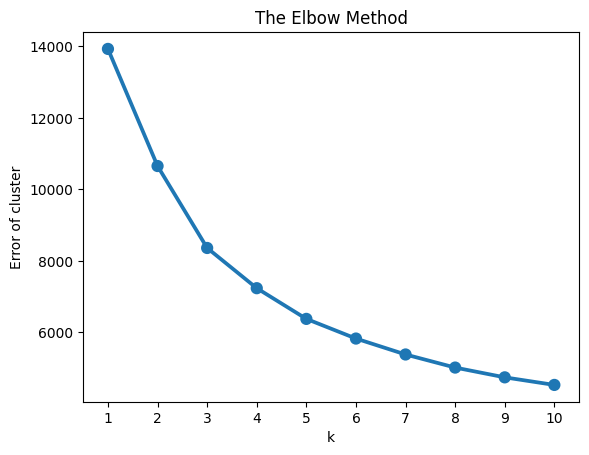

In [82]:
X_cluster = df[['product_size_large_count', 'product_size_small_count', 'product_line_road_count', 'average_profit_per_transaction']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()



In [83]:
model = KMeans(n_clusters = 3, random_state=12)
model.fit(X_cluster_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3, random_state=12)

In [84]:
# temp = X_cluster.assign(cluster = model.labels_)

In [85]:
X_cluster.head()

,product_size_large_count,product_size_small_count,product_line_road_count,average_profit_per_transaction
0,0,2,3,274.371818
1,0,0,0,742.086667
2,1,0,0,110.285000
3,2,2,3,399.156667
4,1,0,0,789.310000


In [86]:
X_cluster = X_cluster.assign(cluster = model.labels_)

scaler2 = MinMaxScaler(feature_range=(1, 20))
scaler2.fit(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))
X_cluster['average_profit_per_transaction'] = scaler2.transform(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))

In [87]:
marker_size = X_cluster['average_profit_per_transaction']
marker_color = X_cluster['cluster']

fig = go.Scatter3d(x=X_cluster['product_size_small_count'] + 1,
                 y=X_cluster['product_line_road_count'] + 1,
                 z=X_cluster['product_size_large_count'] + 1,
                 marker=dict(size=marker_size,
                             color=marker_color,
                             opacity=0.9,
                             reversescale=True),
                            #  colorscale='Blues'),
                   line=dict(width=0.02),
                   mode='markers')

figure = go.Figure(fig)


figure.update_layout(scene=dict(xaxis=dict(title='product_size_small_count'),
                                yaxis=dict(title='product_line_road_count'),
                                zaxis=dict(title='product_line_large_count')),
                     width=800,
                     height=800)

figure.show()

Start preparing to model data to get target customers.

Prepare data for training.

In [88]:
df_new.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')

In [89]:
df2 = df_copy
df2.columns

Index(['customer_id', 'transaction_count', 'days_since_first_purchase',
       'days_since_last_purchase', 'profit_sum', 'online_order_count',
       'product_line_mountain_count', 'product_line_road_count',
       'product_line_standard_count', 'product_line_touring_count',
       'product_class_high_count', 'product_class_low_count',
       'product_class_medium_count', 'product_size_large_count',
       'product_size_medium_count', 'product_size_small_count', 'gender',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'state', 'property_valuation', 'average_profit_per_transaction'],
      dtype='object')

In [90]:
df2 = df2[['gender', 'past_3_years_bike_related_purchases', 'age', 'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation', 'job_industry_category', 'average_profit_per_transaction']]
df2.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'age',
       'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation',
       'job_industry_category', 'average_profit_per_transaction'],
      dtype='object')

In [91]:
df2 = df2.fillna({'job_industry_category':'No Info', 'tenure':0})

df2 = pd.get_dummies(data=df2, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])

In [92]:
X2_unscaled = df2.drop(columns = ['average_profit_per_transaction'])
y2 = df2['average_profit_per_transaction']

scaler = StandardScaler()
scaler.fit(X2_unscaled)
X2 = scaler.transform(X2_unscaled)

rf_model_file = 'kpmg_rf_model_file2.pkl'

cv_hyperparameter_rf(X2, y2)

MEAN CROSS-VALIDATION SCORE:  -0.002474588468783301
BEST HYPERPARAMETERS:  {'max_depth': 3, 'n_estimators': 300}
Parameter tuning with cross-validation finished. Starting the model training with best performing parameters...
MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL:  186.9124649039006


RandomForestRegressor(max_depth=3, n_estimators=300)

In [93]:
y.mean()

545.0305051807222

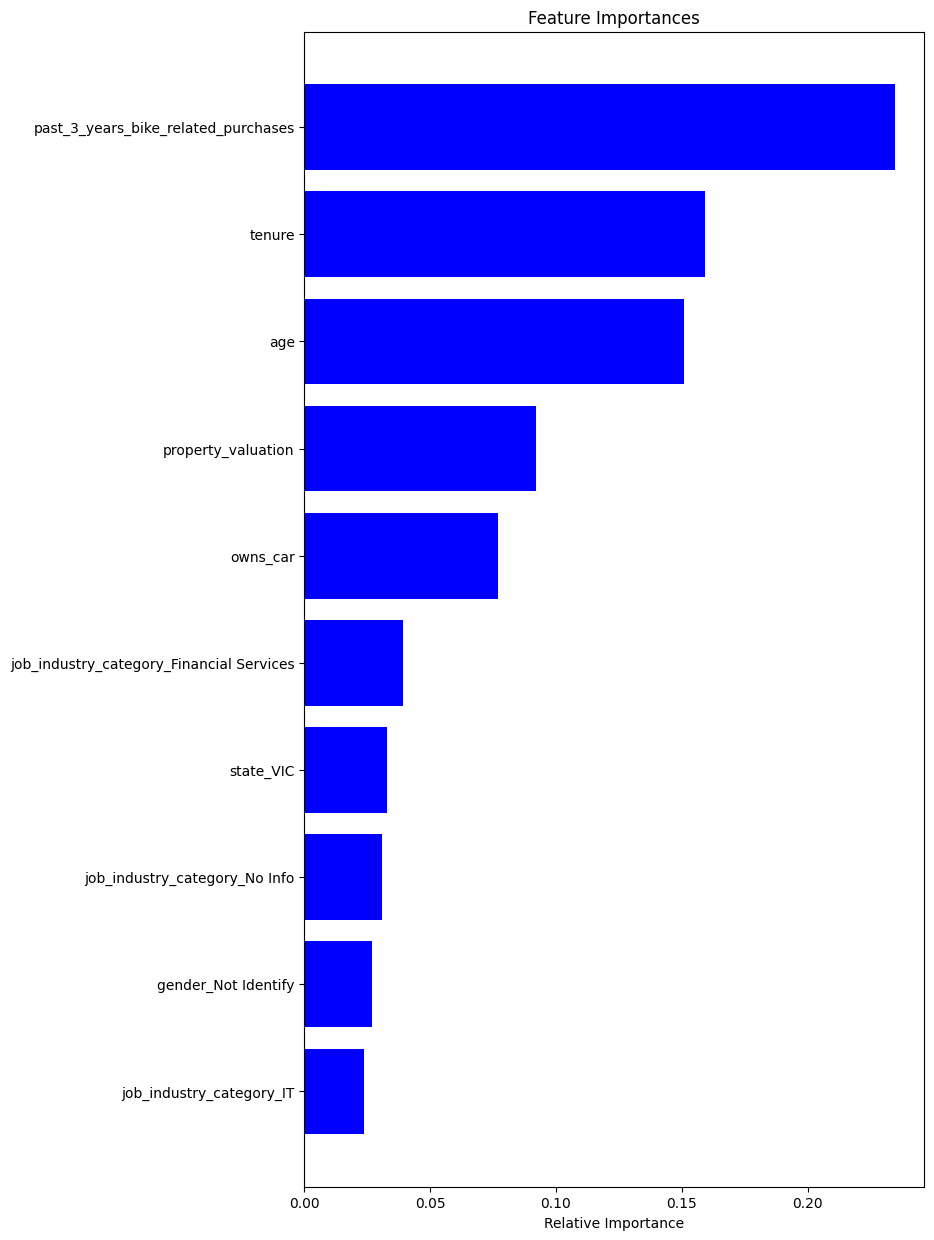

In [94]:
rf_model_file = 'kpmg_rf_model_file2.pkl'
rf_model = pickle.load(open(rf_model_file, 'rb'))

features = [i.split("__")[0] for i in X2_unscaled.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

fig, ax = plt.subplots(figsize=(8, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Process the new customers data for prediction.

In [95]:
df_new.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')

In [96]:
df_new = df_new[['gender', 'past_3_years_bike_related_purchases', 'DOB', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation']]
df_new.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'DOB',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation'],
      dtype='object')

In [97]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   gender                               1000 non-null   object        
 1   past_3_years_bike_related_purchases  1000 non-null   int64         
 2   DOB                                  983 non-null    datetime64[ns]
 3   job_industry_category                835 non-null    object        
 4   wealth_segment                       1000 non-null   object        
 5   owns_car                             1000 non-null   object        
 6   tenure                               1000 non-null   int64         
 7   state                                1000 non-null   object        
 8   property_valuation                   1000 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 70.4+ KB


In [98]:
df_new['age'] = (ref_date - df_new['DOB']).dt.days / 365
df_new['age'] = df_new['age'].fillna(df_new['age'].mean())
df_new['age'] = df_new['age'].astype(int)
df_new.head(3)

<ipython-input-98-a892acc1939f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-98-a892acc1939f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-98-a892acc1939f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age
0,Male,86,1957-07-12,Manufacturing,Mass Customer,Yes,14,QLD,6,60
1,Male,69,1970-03-22,Property,Mass Customer,No,16,NSW,11,47
2,Female,10,1974-08-28,Financial Services,Affluent Customer,No,10,VIC,5,43


In [99]:
df_new['owns_car'] = df_new['owns_car'].replace({'Yes':1, 'No':0})
df_new.head(3)

<ipython-input-99-b890c4b8d4ba>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age
0,Male,86,1957-07-12,Manufacturing,Mass Customer,1,14,QLD,6,60
1,Male,69,1970-03-22,Property,Mass Customer,0,16,NSW,11,47
2,Female,10,1974-08-28,Financial Services,Affluent Customer,0,10,VIC,5,43


In [100]:
df_new['state'] = df_new['state'].replace({'New South Wales':'NSW', 'Victoria':'VIC'})
df_new['state'].unique()

<ipython-input-100-b422c3a2b3d7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['QLD', 'NSW', 'VIC'], dtype=object)

In [101]:
df_new = df_new.drop(columns='DOB')
df_new.head(3)

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age
0,Male,86,Manufacturing,Mass Customer,1,14,QLD,6,60
1,Male,69,Property,Mass Customer,0,16,NSW,11,47
2,Female,10,Financial Services,Affluent Customer,0,10,VIC,5,43


In [102]:
df_new = df_new.fillna({'job_industry_category':'No Info'})

In [103]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   job_industry_category                1000 non-null   object
 3   wealth_segment                       1000 non-null   object
 4   owns_car                             1000 non-null   int64 
 5   tenure                               1000 non-null   int64 
 6   state                                1000 non-null   object
 7   property_valuation                   1000 non-null   int64 
 8   age                                  1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [104]:
X3_unscaled = pd.get_dummies(data=df_new, columns=['gender', 'job_industry_category', 'wealth_segment', 'state'])

Fit the new customers data to the model to get prediction.

In [105]:
scaler = StandardScaler()
scaler.fit(X3_unscaled)
X3 = scaler.transform(X3_unscaled)

rf_model_file = 'kpmg_rf_model_file2.pkl'
rf_model = pickle.load(open(rf_model_file, 'rb'))

y3_pred = rf_model.predict(X3)


In [106]:
y3_pred.dtype

dtype('float64')

In [107]:
df_new_pred = df_new_copy
df_new_pred.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [108]:
df_new_pred['predicted_average_profit_per_transaction'] = y3_pred
df_new_pred.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,predicted_average_profit_per_transaction
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750,549.675199
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750,549.748800
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750,525.315573
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125,545.930085
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125,546.342022


In [109]:
df_new_pred.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value',
       'predicted_average_profit_per_transaction'],
      dtype='object')

In [110]:
df_new_pred = df_new_pred[['first_name', 'last_name', 'gender', 'DOB', 'address', 'postcode', 'state','predicted_average_profit_per_transaction']]
df_new_pred.head(100)

,first_name,last_name,gender,DOB,address,postcode,state,predicted_average_profit_per_transaction
0,Chickie,Brister,Male,1957-07-12,45 Shopko Center,4500,QLD,549.675199
1,Morly,Genery,Male,1970-03-22,14 Mccormick Park,2113,NSW,549.748800
2,Ardelis,Forrester,Female,1974-08-28,5 Colorado Crossing,3505,VIC,525.315573
3,Lucine,Stutt,Female,1979-01-28,207 Annamark Plaza,4814,QLD,545.930085
4,Melinda,Hadlee,Female,1965-09-21,115 Montana Place,2093,NSW,546.342022
...,...,...,...,...,...,...,...,...
95,Jehu,Prestedge,Male,1999-10-20,88 Annamark Avenue,2138,NSW,548.831688
96,Symon,Mawne,Male,1943-02-08,37439 High Crossing Circle,3350,VIC,540.316328
97,Karlik,Penchen,Male,1994-10-31,5 Nevada Point,4017,QLD,538.439401
98,Bengt,Bilson,Male,1972-11-02,67 Grayhawk Circle,2232,NSW,517.771748


In [111]:
df_new_pred = df_new_pred.sort_values(by='predicted_average_profit_per_transaction', ascending=False)
df_new_pred.head(30)

,first_name,last_name,gender,DOB,address,postcode,state,predicted_average_profit_per_transaction
488,Ariel,McCloid,Male,1994-03-13,99 Quincy Parkway,3630,VIC,576.241432
818,Noak,Sleany,Male,1965-05-04,1 Roth Plaza,3121,VIC,575.127426
113,Meriel,Tapp,Female,1995-08-13,65 Milwaukee Hill,3280,VIC,570.798722
72,Kevina,Ferandez,Female,1999-09-21,9608 Heffernan Drive,4068,QLD,570.367249
254,Lea,Ilyinski,Female,1997-09-25,895 Glendale Park,2026,NSW,570.314255
534,Jacobo,Mucklow,Male,1952-12-04,5512 Ronald Regan Hill,3122,VIC,569.652176
819,Callean,Wass,Male,1988-12-15,0593 Stoughton Center,3073,VIC,568.720933
940,Claudetta,Ricciardiello,Female,1974-04-30,31 Schurz Parkway,3181,VIC,568.398051
733,Yardley,Matten,Male,1991-03-06,74 Everett Court,4408,QLD,568.201639
834,Jared,Fendlow,Male,1963-08-25,6195 Bellgrove Lane,4211,QLD,567.853501


Build clustering based on the latest model.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

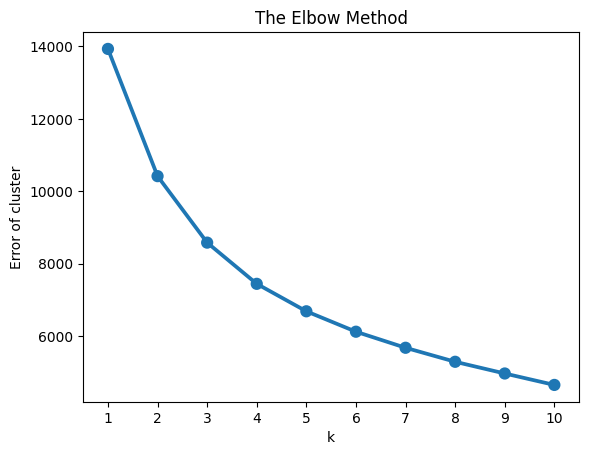

In [112]:
X_cluster = df2[['past_3_years_bike_related_purchases', 'age', 'tenure', 'average_profit_per_transaction']]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

error = []

for k in range(1, 11):
  model = KMeans(n_clusters=k, random_state=12)
  model.fit(X_cluster_scaled)
  error.append(model.inertia_)

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Error of cluster')
sns.pointplot(x=list(range(1, 11)), y=error)
plt.show()

In [113]:
model = KMeans(n_clusters = 3, random_state=12)
model.fit(X_cluster_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3, random_state=12)

In [114]:
# X_cluster = df2[['past_3_years_bike_related_purchases', 'age', 'tenure', 'average_profit_per_transaction']]
X_cluster = X_cluster.assign(cluster = model.labels_)

scaler2 = MinMaxScaler(feature_range=(1, 20))
scaler2.fit(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))
X_cluster['average_profit_per_transaction'] = scaler2.transform(X_cluster['average_profit_per_transaction'].values.reshape(-1, 1))

# scaler2.fit(X_cluster)
# X_cluster = scaler2.transform(X_cluster)

In [115]:
marker_size = X_cluster['average_profit_per_transaction']
marker_color = X_cluster['cluster']

fig = go.Scatter3d(x=X_cluster['past_3_years_bike_related_purchases'],
                 y=X_cluster['age'],
                 z=X_cluster['tenure'],
                 marker=dict(size=marker_size,
                             opacity=0.9,
                             color=marker_color,
                             reversescale=True),
                            #  colorscale='Blues'),
                   line=dict(width=0.02),
                   mode='markers')

figure = go.Figure(fig)


figure.update_layout(scene=dict(xaxis=dict(title='past_3_years_bike_related_purchases'),
                                yaxis=dict(title='age'),
                                zaxis=dict(title='tenure')),
                     width=800,
                     height=800)

figure.show()